In [28]:
import sys
sys.path.append('../../30_data_tools/')
from pathlib import Path
from random import randrange
from PIL import Image
import numpy as np

In [3]:
from helper import load_dotenv

In [177]:
TILE_SIZE = 280
MIN_MIDTONE_SHARE = 0.05

In [4]:
dotenv = load_dotenv()

In [194]:
jpgs = list(dotenv['DATA_DIR'].glob('./*/halftone600dpi/*.jpg'))

In [274]:
def process_img( img ):
    relevant_tiles = []
    non_relevant_tiles = []
    out_img = np.zeros((img.size[1],img.size[0]))
    
    left = 0
    top = 0
    
    while left < img.size[0] or top < img.size[1]:
        tile = img.crop((
            left,top,
            left+TILE_SIZE,top+TILE_SIZE
        ))
        np_tile = np.array(tile)
        is_relevant = False
        
        for i in range(np_tile.shape[2]):
            sep = np_tile[:,:,i]
        
            midtone_share = sep[(sep > 8) & (sep < 247)].shape[0] / (sep.shape[0] * sep.shape[1])
            if midtone_share > MIN_MIDTONE_SHARE:
                is_relevant = True
                break
    
        if is_relevant:
            relevant_tiles.append((midtone_share,tile))
            out_img[
                top:top+TILE_SIZE,
                left:left+TILE_SIZE
            ] = 1
        else:
            non_relevant_tiles.append((midtone_share,tile))
        
    
        if left < img.size[0]:
            left += round(TILE_SIZE / 2)
        elif top < img.size[1]:
            left = 0
            top += round(TILE_SIZE / 2)
        else:
            break

    return out_img

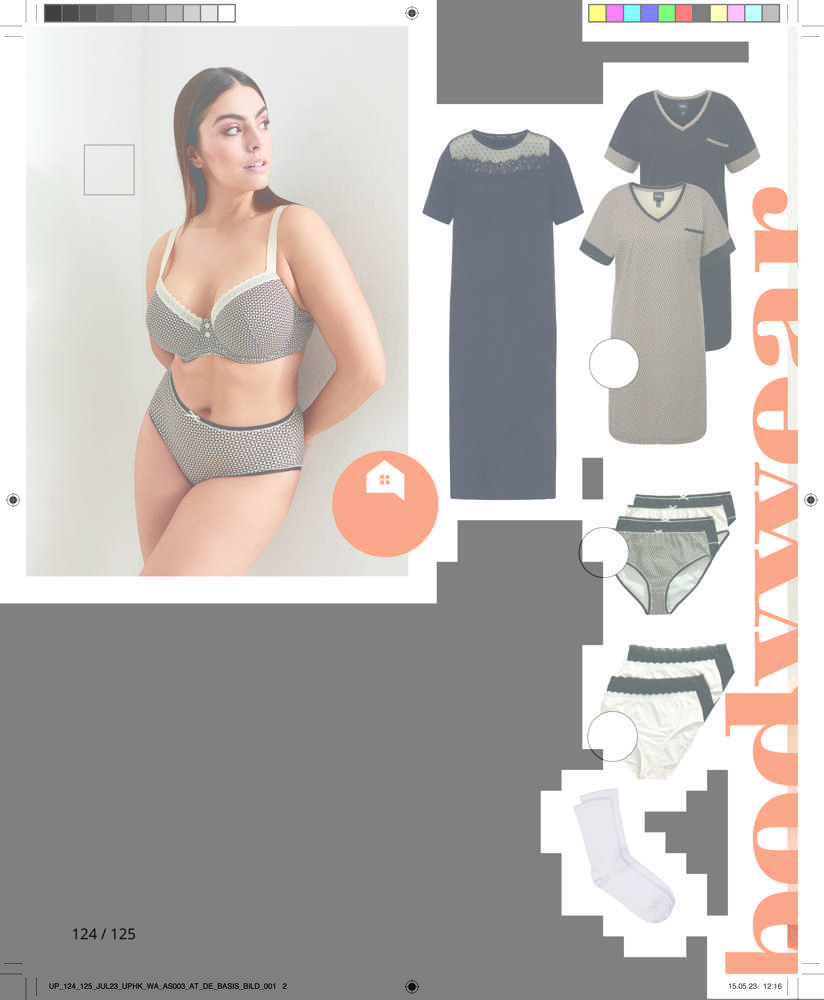

In [314]:
example = jpgs[randrange(len(jpgs))]
img = Image.open(example)
out_img = process_img( img )

blended = Image.blend(img, Image.fromarray((out_img * 255).astype('uint8')).convert('CMYK'), alpha=0.5)
blended = blended.resize((int(blended.width / blended.height * 1000),1000))

blended